In [239]:
## importing all needed packages

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import time
import warnings
from statsmodels.imputation import mice
warnings.filterwarnings('ignore')

from matplotlib import rcParams

import plotly.offline as py 
import plotly.figure_factory as ff 
import plotly.graph_objs as go 


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet


from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from itertools import chain, combinations
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
#To plot figs on jupyter
%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 16,8

In [240]:
# read dataset
df = pd.read_csv("cleaned_data.csv", index_col=0)
df.head()

,emp_length,annual_income,debt_to_income,delinq_2y,inquiries_last_12m,total_credit_lines,total_credit_limit,total_credit_utilized,num_historical_failed_to_pay,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_active_debit_accounts,total_debit_limit,num_mort_accounts,account_never_delinq_percent,public_record_bankrupt,loan_amount,term,interest_rate,paid_total,homeownership_OWN,homeownership_RENT,verified_income_Source Verified,...,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G4,initial_listing_status_whole
0,3.00,90000.00,18.01,0,6,28,70795,38767,0,1250,2,5,5.00,2,11100,1,92.90,0,28000,60,14.07,1999.33,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,10.00,40000.00,5.04,0,1,30,28800,4321,1,0,0,11,8.00,3,16500,0,100.00,1,5000,36,12.61,499.12,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3.00,40000.00,21.15,0,4,31,24193,16000,0,432,1,13,7.00,3,4300,0,93.50,0,2000,36,17.09,281.80,0,1,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.00,30000.00,10.16,0,0,4,25400,4997,1,0,1,1,15.00,2,19400,0,100.00,0,21600,36,6.72,3312.89,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,10.00,35000.00,57.96,0,7,22,69839,52722,0,0,1,6,4.00,10,32700,0,100.00,0,23000,36,14.07,2324.65,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [241]:
df.isnull().sum()

emp_length                      817
annual_income                     0
debt_to_income                   24
delinq_2y                         0
inquiries_last_12m                0
                               ... 
sub_grade_F4                      0
sub_grade_F5                      0
sub_grade_G1                      0
sub_grade_G4                      0
initial_listing_status_whole      0
Length: 76, dtype: int64

In [242]:
df = df.rename({'verified_income_Source Verified':'verified_income_Source_Verified','loan_status_Late (16-30 days)': 'loan_status_Late_16_30_days', 'loan_status_Late (31-120 days)': 'loan_status_Late_31_120_days','loan_status_Fully Paid':'loan_status_Fully_Paid','loan_status_In Grace Period':'loan_status_In_Grace_Period'}, axis=1)

### Imputing all missing values using MICE

imputed_data = mice.MICEData(df)
imputed_data.set_imputer('x1', formula='x2 + np.square(x2) + x3')
for j in range(20):
    imputed_data.update_all()

- we will be using this imputed data for model building. For EDA/ visualization we will used the cleaned data.

In [243]:

model_data = imputed_data.data.copy()


In [244]:
## Separating into dependent and independent variables
Y = pd.DataFrame(model_data['interest_rate'])
model_data.drop(['interest_rate'],axis=1,inplace=True)
X = model_data


In [246]:
features = X.columns
features

Index(['emp_length', 'annual_income', 'debt_to_income', 'delinq_2y',
       'inquiries_last_12m', 'total_credit_lines', 'total_credit_limit',
       'total_credit_utilized', 'num_historical_failed_to_pay',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_active_debit_accounts', 'total_debit_limit', 'num_mort_accounts',
       'account_never_delinq_percent', 'public_record_bankrupt', 'loan_amount',
       'term', 'paid_total', 'homeownership_OWN', 'homeownership_RENT',
       'verified_income_Source_Verified', 'verified_income_Verified',
       'loan_purpose_credit_card', 'loan_purpose_debt_consolidation',
       'loan_purpose_home_improvement', 'loan_purpose_house',
       'loan_purpose_major_purchase', 'loan_purpose_medical',
       'loan_purpose_moving', 'loan_purpose_other',
       'loan_purpose_renewable_energy', 'loan_purpose_small_business',
       'loan_purpose_vacation', 'applica

In [446]:
## splitting into train and test
train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size=0.20, random_state=42) 


In [272]:
### My reason for using the below methods is because it will help me in feature selection

lm_lasso = Lasso()
lm_ridge = Ridge()
lm_elastic = ElasticNet()

lm_lasso
lm_ridge
lm_elastic


ElasticNet()

In [273]:
lm_lasso.fit(train_x, train_y)
lm_ridge.fit(train_x, train_y)
lm_elastic.fit(train_x, train_y)

ElasticNet()

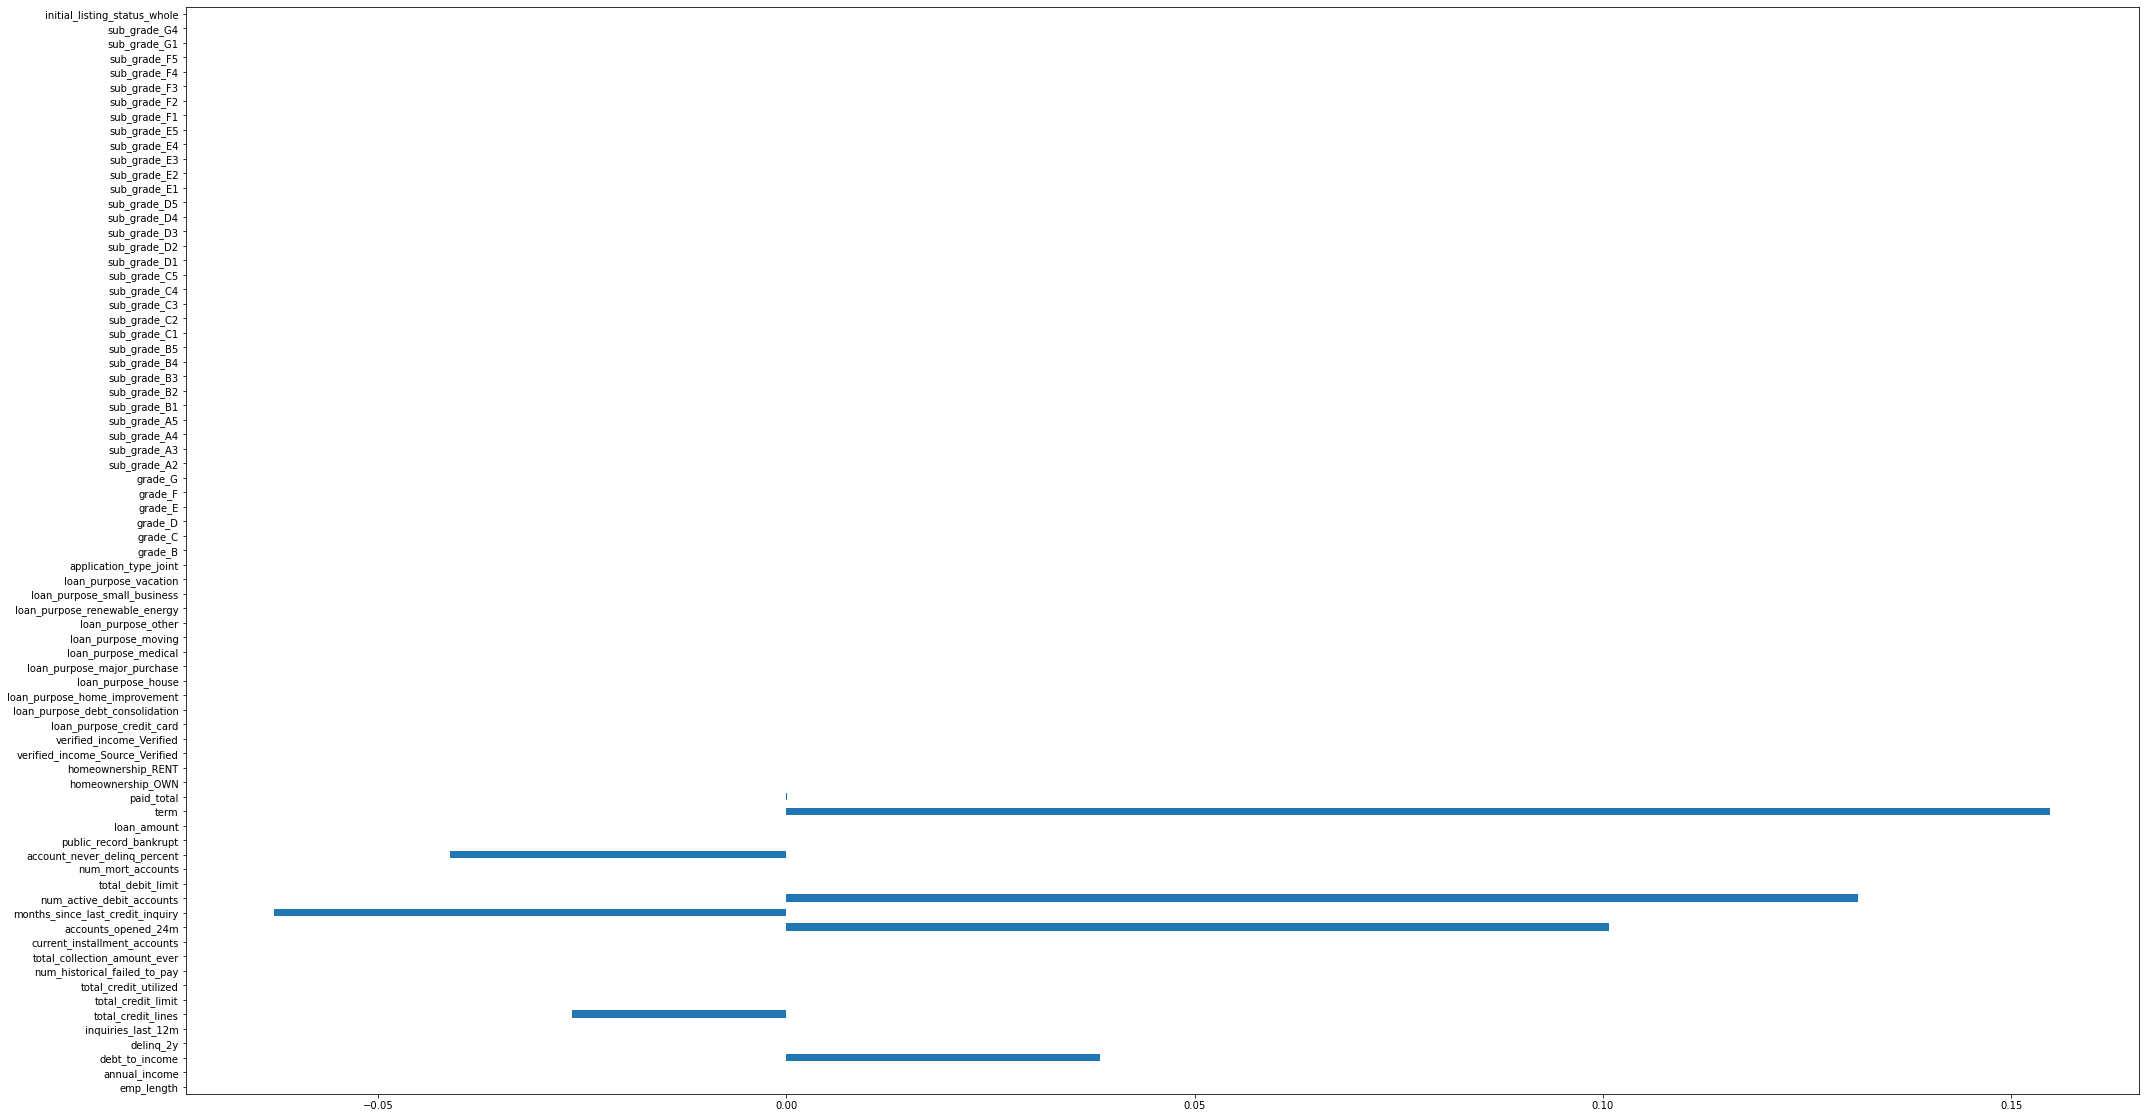

In [274]:
### plotting lasso variables 
plt.figure(figsize=(35,20))
ft_importances_lm_lasso = pd.Series(lm_lasso.coef_, index = independent.columns)
ft_importances_lm_lasso.plot(kind='barh')
plt.show();

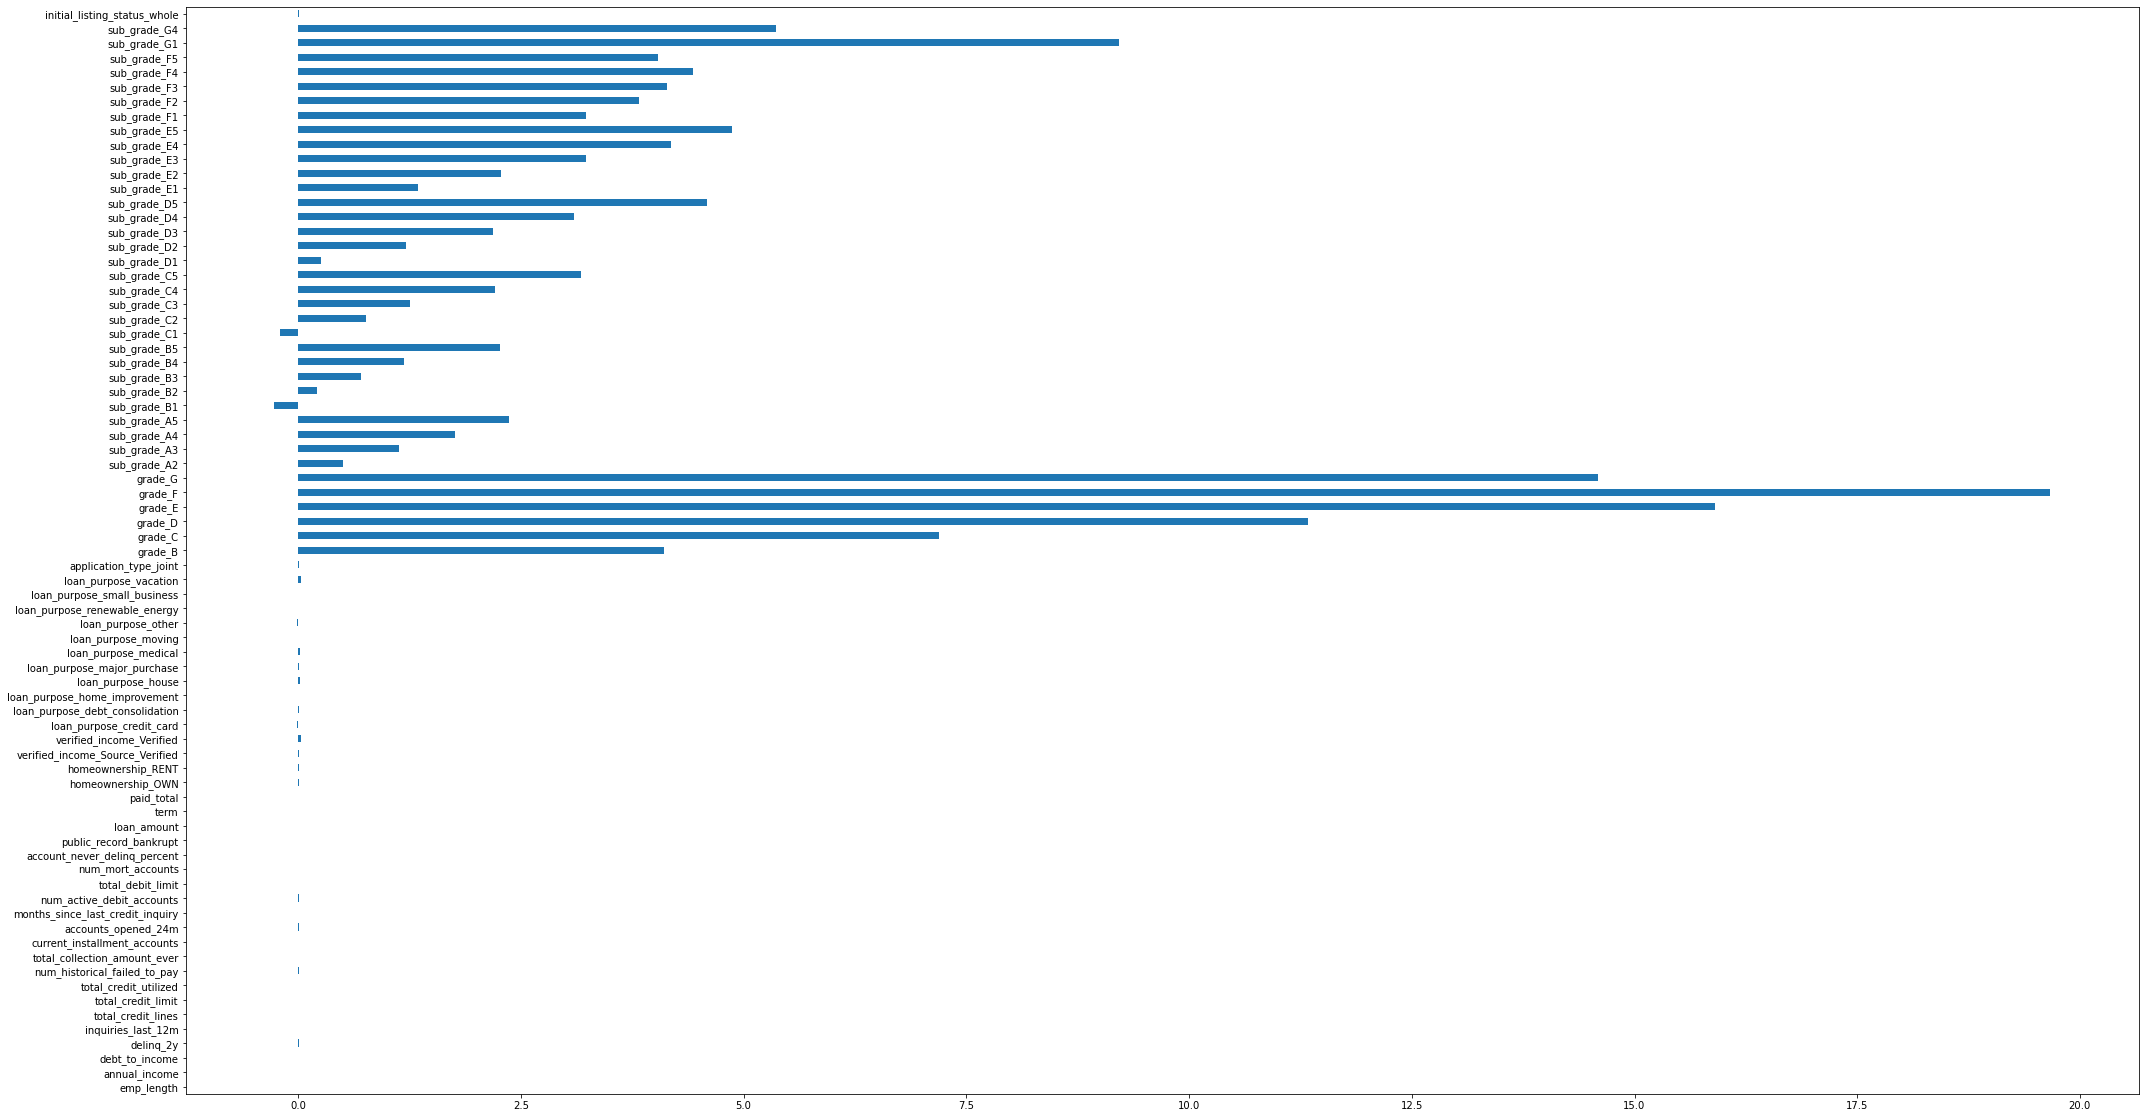

In [294]:
### Printing Ridge variables

plt.figure(figsize=(35,20))
ft_importances_lm_ridge = pd.Series(lm_ridge.coef_[0], index = independent.columns)
ft_importances_lm_ridge.plot(kind='barh')
plt.show();

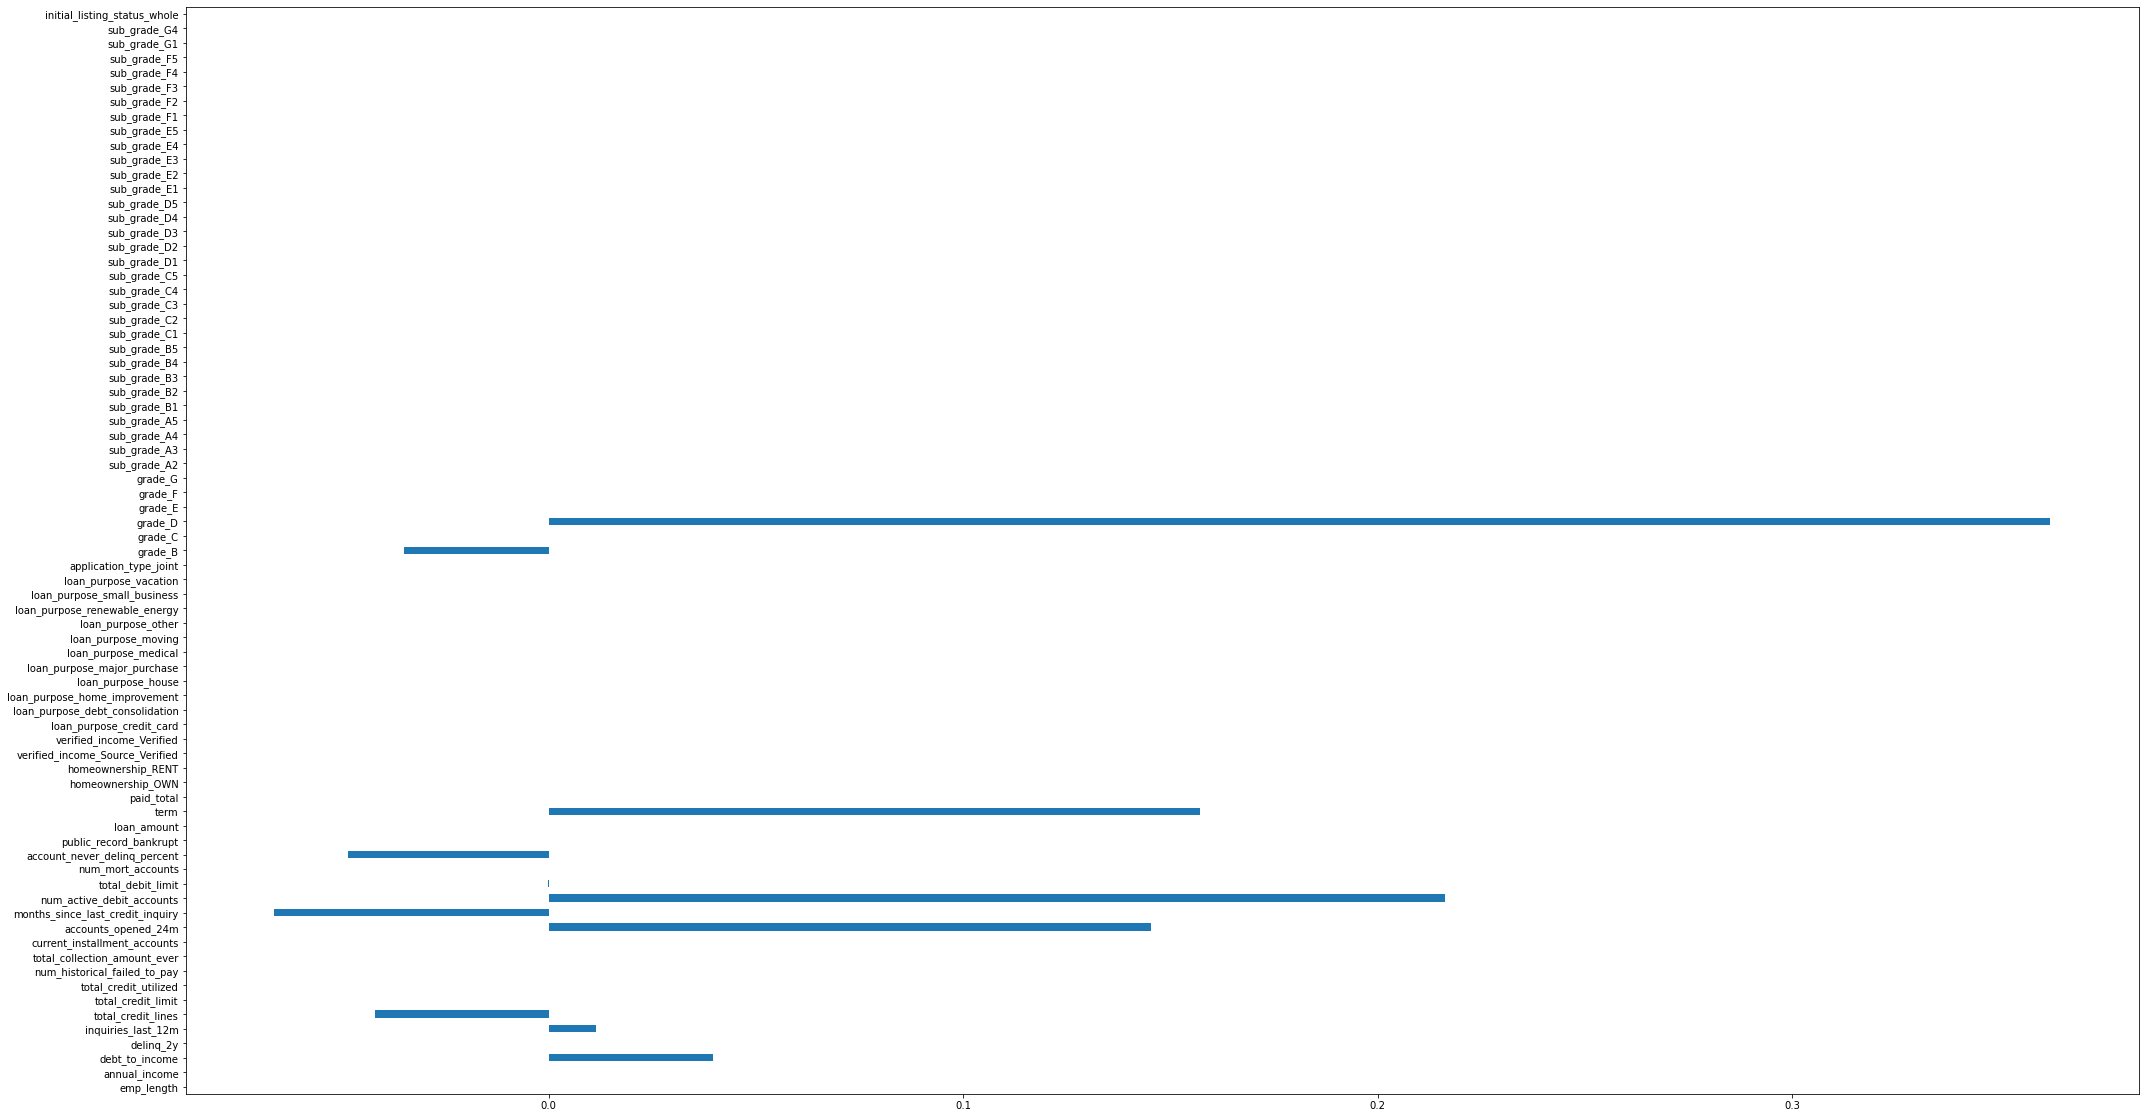

In [295]:
## printing elastic net variable
plt.figure(figsize=(35,20))
ft_importances_lm_elastic = pd.Series(lm_elastic.coef_, index = independent.columns)
ft_importances_lm_elastic.plot(kind='barh')
plt.show();

In [296]:
ft_importances_lm_elastic

emp_length                     -0.00
annual_income                  -0.00
debt_to_income                  0.04
delinq_2y                       0.00
inquiries_last_12m              0.01
                                ... 
sub_grade_F4                    0.00
sub_grade_F5                    0.00
sub_grade_G1                    0.00
sub_grade_G4                    0.00
initial_listing_status_whole   -0.00
Length: 75, dtype: float64

In [298]:
# R2 Value

print("RSquare Value for Lasso Regression Test Data is-")
np.round(lm_lasso.score(test_x,test_y)*100,2)


RSquare Value for Lasso Regression Test Data is-


31.82

In [299]:
print("RSquare Value for Ridge Regression Test Data is-")
np.round(lm_ridge.score(test_x,test_y)*100,2)

RSquare Value for Ridge Regression Test Data is-


99.94

In [300]:
print("RSquare Value for Elastic Net Regression Test Data is-")
np.round(lm_elastic.score(test_x,test_y)*100,2)

RSquare Value for Elastic Net Regression Test Data is-


34.86

In [301]:

# Predict on Training and Test Data

predict_test_lasso = lm_lasso.predict(test_x)
predict_test_ridge = lm_ridge.predict(test_x)
predict_test_elastic = lm_elastic.predict(test_x)


In [302]:
## Checking some metric on test data

mse_lasso = np.round(metrics.mean_squared_error(test_y, predict_test_lasso),2)
errors_test_lasso = abs(predict_test_lasso - test_y)
mape_test_lasso = 100 * np.mean(errors_test_lasso / test_y)
accuracy_test_lasso = 100 - mape_test_lasso

print("Lasso Regression Mean Squared ERROR (MSE) for Test Data is {}".format(mse_lasso))
print("Lasso MAPE for Test Data is {}%".format(mape_test_lasso))
print("Lasso Accuracy for Test Data is {}%".format(accuracy_test_lasso))

mse_ridge = np.round(metrics.mean_squared_error(test_y, predict_test_ridge),2)
errors_test_ridge = abs(predict_test_ridge - test_y)
mape_test_ridge = 100 * np.mean(errors_test_ridge / test_y)
accuracy_test_ridge = 100 - mape_test_ridge

print("Ridge Regression Mean Squared ERROR (MSE) for Test Data is {}".format(mse_ridge))
print("Ridge MAPE for Test Data is {}%".format(mape_test_ridge))
print("Ridge Accuracy for Test Data is {}%".format(accuracy_test_ridge))

mse_elastic = np.round(metrics.mean_squared_error(test_y, predict_test_elastic),2)
errors_test_elastic = abs(predict_test_elastic - test_y)
mape_test_elastic = 100 * np.mean(errors_test_elastic / test_y)
accuracy_test_elastic = 100 - mape_test_elastic

print("Elastic Regression Mean Squared ERROR (MSE) for Test Data is {}".format(mse_elastic))
print("Elastic MAPE for Test Data is {}%".format(mape_test_elastic))
print("Elastic Accuracy for Test Data is {}%".format(accuracy_test_elastic))

Lasso Regression Mean Squared ERROR (MSE) for Test Data is 18.08
Lasso MAPE for Test Data is 42.444260223429595%
Lasso Accuracy for Test Data is 57.555739776570405%
Ridge Regression Mean Squared ERROR (MSE) for Test Data is 0.02
Ridge MAPE for Test Data is 0.5952949645086133%
Ridge Accuracy for Test Data is 99.40470503549139%
Elastic Regression Mean Squared ERROR (MSE) for Test Data is 17.27
Elastic MAPE for Test Data is 42.80617681422897%
Elastic Accuracy for Test Data is 57.19382318577103%


In [389]:
## creating av evaluation function to run models

def evaluate(model,X_train,X_test,Y_train,Y_test):
    
    model.fit(X_train,Y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
    errors_train = abs(predictions_train - np.array(Y_train))
    errors_test = abs(predictions_test - np.array(Y_test))
    
    Y_test = np.array(Y_test)
    Y_train = np.array(Y_train)
    mape_train = 100 * np.mean(errors_train / Y_train)
    mape_test = 100 * np.mean(errors_test / Y_test)
    
    accuracy_train = 100 - mape_train
    accuracy_test = 100 - mape_test
    
    print('Model Performance')
    print('Average Error(Train Data): {:0.4f} of int rate.'.format(np.mean(errors_train)))
    print('Average Error(Test Data): {:0.4f} of int rate.'.format(np.mean(errors_test)))
    
    print('Accuracy(Train Data) = {:0.2f}%.'.format(accuracy_train))
    print('Accuracy(Test Data) = {:0.2f}%.'.format(accuracy_test))
    
    print('Mape(Train Data): {:0.4f} of int rate'.format(mape_train))
    print('Mape(Test Data): {:0.4f} of int rate'.format(mape_test))
 
    return accuracy_train,accuracy_test

In [353]:
# prepare a range of alpha values to test
alphas = np.array([5,10,15,20,25,30])

In [354]:
# Tuning the Hyperparameter Alpha of Lasso Regression

model = Lasso()
grid_lasso = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid_lasso.fit(train_x,train_y)
print(grid_lasso)

# summarize the results of the grid search
print(grid_lasso.best_score_)
print(grid_lasso.best_estimator_)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([ 5, 10, 15, 20, 25, 30])})
0.20592111984857525
Lasso(alpha=5)


In [355]:
# Tuning the Hyperparameter Alpha of Ridge Regression

model = Ridge()
grid_ridge = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid_ridge.fit(train_x,train_y)
print(grid_ridge)

# summarize the results of the grid search
print(grid_ridge.best_score_)
print(grid_ridge.best_estimator_)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 5, 10, 15, 20, 25, 30])})
0.9894015387961765
Ridge(alpha=5)


In [356]:
# Tuning the Hyperparameter Alpha of Elastic Regression

model = ElasticNet()
grid_elastic = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid_elastic.fit(train_x,train_y)
print(grid_elastic)

# summarize the results of the grid search
print(grid_elastic.best_score_)
print(grid_elastic.best_estimator_)

GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': array([ 5, 10, 15, 20, 25, 30])})
0.23375559290180575
ElasticNet(alpha=5)


In [357]:
### running lasso with best parameters

lm_lasso_best = Lasso(alpha=5, copy_X=True, fit_intercept=True, max_iter=1000,
                      normalize=False, positive=False, precompute=False, random_state=None,
                      selection='cyclic', tol=0.0001, warm_start=False)


evaluate(lm_lasso_best, train_x, test_x, train_y, test_y)

Model Performance
Average Error(Train Data): 4.2333 of int rate.
Average Error(Test Data): 4.3809 of int rate.
Accuracy(Train Data) = 60.10%.
Accuracy(Test Data) = 58.67%.
Mape(Train Data): 39.8982 of int rate
Mape(Test Data): 41.3320 of int rate


(60.101821605504526, 58.66796847697986)

In [358]:
### looking at the best set of variables which comes out from lasso regression.
np.array(features)[lm_lasso_best.coef_ != 0]


array(['annual_income', 'debt_to_income', 'total_credit_limit',
       'total_credit_utilized', 'total_collection_amount_ever',
       'total_debit_limit', 'loan_amount', 'term', 'paid_total'],
      dtype=object)

In [359]:
lm_ridge_best = Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto', tol=0.001)

evaluate(lm_ridge_best,train_x, test_x, train_y, test_y)

Model Performance
Average Error(Train Data): 0.1761 of int rate.
Average Error(Test Data): 0.1853 of int rate.
Accuracy(Train Data) = 98.19%.
Accuracy(Test Data) = 98.10%.
Mape(Train Data): 1.8087 of int rate
Mape(Test Data): 1.8999 of int rate


(98.19131386052526, 98.10013918617896)

In [362]:
## Ridge will use all features but will penalize the corelated variables close to zero.
np.array(features)[lm_ridge_best.coef_[0] != 0]


array(['emp_length', 'annual_income', 'debt_to_income', 'delinq_2y',
       'inquiries_last_12m', 'total_credit_lines', 'total_credit_limit',
       'total_credit_utilized', 'num_historical_failed_to_pay',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_active_debit_accounts', 'total_debit_limit',
       'num_mort_accounts', 'account_never_delinq_percent',
       'public_record_bankrupt', 'loan_amount', 'term', 'paid_total',
       'homeownership_OWN', 'homeownership_RENT',
       'verified_income_Source_Verified', 'verified_income_Verified',
       'loan_purpose_credit_card', 'loan_purpose_debt_consolidation',
       'loan_purpose_home_improvement', 'loan_purpose_house',
       'loan_purpose_major_purchase', 'loan_purpose_medical',
       'loan_purpose_moving', 'loan_purpose_other',
       'loan_purpose_renewable_energy', 'loan_purpose_small_business',
       'loan_purpose_vacation', '

In [363]:
lm_elastic_best = ElasticNet(alpha=5, copy_X=True, fit_intercept=True, l1_ratio=0.5,
                              max_iter=1000, normalize=False, positive=False, precompute=False,
                              random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

evaluate(lm_elastic_best,train_x, test_x, train_y, test_y)

Model Performance
Average Error(Train Data): 4.2855 of int rate.
Average Error(Test Data): 4.4343 of int rate.
Accuracy(Train Data) = 59.69%.
Accuracy(Test Data) = 58.22%.
Mape(Train Data): 40.3136 of int rate
Mape(Test Data): 41.7792 of int rate


(59.68639515123061, 58.22084402779389)

In [364]:
### looking at the best set of variables which comes out from Elastic net regression.
np.array(features)[lm_elastic_best.coef_ != 0]


array(['annual_income', 'debt_to_income', 'total_credit_limit',
       'total_credit_utilized', 'total_collection_amount_ever',
       'months_since_last_credit_inquiry', 'total_debit_limit',
       'account_never_delinq_percent', 'loan_amount', 'term',
       'paid_total'], dtype=object)

# Trying XGBOOST

In [367]:
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from collections import OrderedDict

In [368]:
numb_cols = independent.select_dtypes(include=("int64","float64"))

cat_cols = independent.select_dtypes(include=("object"))

In [372]:

every_column_non_categorical= [col for col in independent.columns if col not in cat_cols ]

#log transform skewed numeric features:
numeric_feats = independent[every_column_non_categorical].dtypes[independent.dtypes != "object"].index


independent[numeric_feats] = np.log1p(independent[numeric_feats])



In [374]:
## splitting into train and test
train_x, test_x, train_y, test_y = train_test_split(independent,dependent, test_size=0.20, random_state=42) 


In [375]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.01,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [376]:
model.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=12, num_parallel_tree=1,
             random_state=42, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, subsample=0.6, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:>

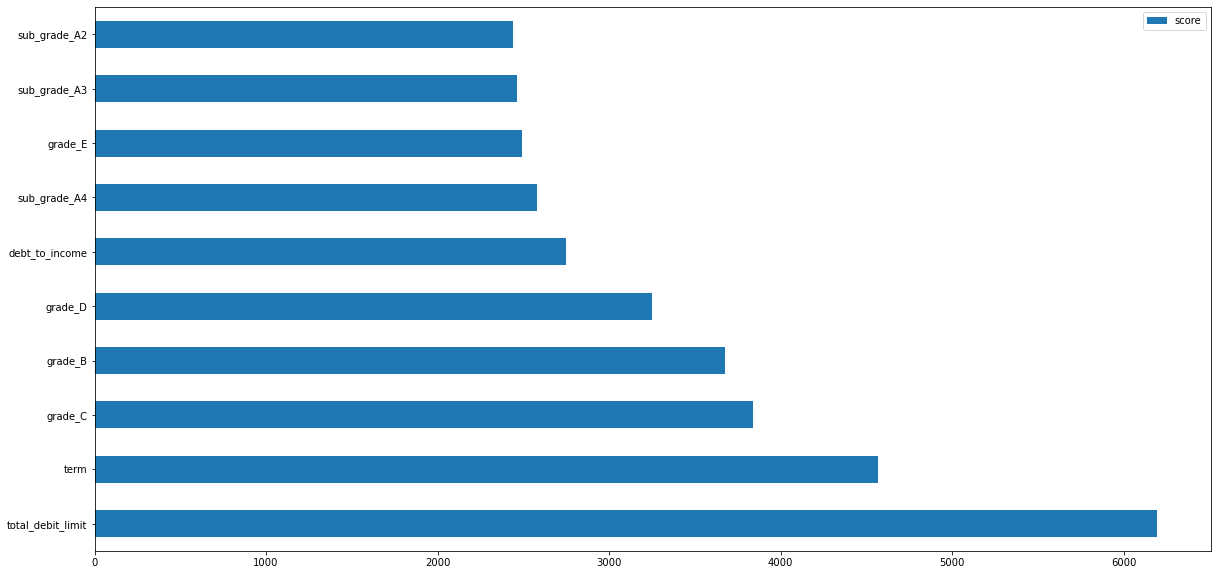

In [382]:

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 10 features

- We can see that many variables common variables came to be important in xgboost as well as compared to the lasso regresssion.
- debt_to_income, total_debit_limit, term. These variables were common in both the models.

In [391]:
## creating the xgb model using only top 10 features to compares the results with lasso regression.
model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.01,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 
model_2.fit(train_x[['sub_grade_A2','sub_grade_A3','grade_E','sub_grade_A4','grade_D','grade_B','grade_C','term','total_debit_limit','debt_to_income']],train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=12, num_parallel_tree=1,
             random_state=42, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, subsample=0.6, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [392]:
evaluate(model_2, train_x, test_x, train_y, test_y)

Model Performance
Average Error(Train Data): 5.4593 of int rate.
Average Error(Test Data): 5.6563 of int rate.
Accuracy(Train Data) = 50.14%.
Accuracy(Test Data) = 48.28%.
Mape(Train Data): 49.8596 of int rate
Mape(Test Data): 51.7185 of int rate


(50.14042789077527, 48.28153351976081)

# Final Results/ Conclusions

- The lasso model (MAPE) is lower as compared to the xgb model as show.
- None of the models perform extremly well. The regression methods assumes a linear relation relationship between the dependent and independent method whereas the tree based method does have any such assumptions.
- After EDA, it was understood that there was no linear relationship between any independent variable with interest rate. We could have gotten linearity by probably transforming the variables.

In [491]:
## Plotting results for xgboost just to visualize the results

a=pd.DataFrame(model.predict(test_x))
a.columns = ['predicted']
b=test_y.reset_index()
b = pd.DataFrame(b['interest_rate'])


dummy = pd.DataFrame(pd.concat([b, a], axis=1, ignore_index=True))
dummy.columns = ['Actual','predicted']
#dummy



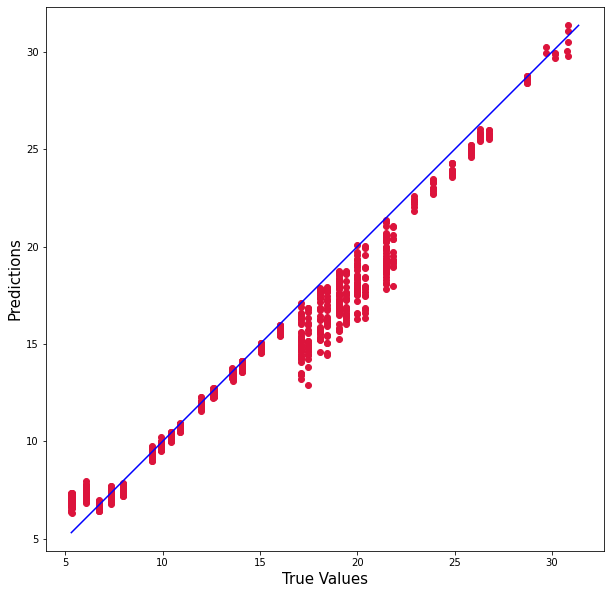

In [493]:
plt.figure(figsize=(10,10))
plt.scatter(dummy['Actual'], dummy['predicted'], c='crimson')

p1 = max(max(dummy['predicted']), max(dummy['Actual']))
p2 = min(min(dummy['predicted']), min(dummy['Actual']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

- As the points are below the perfect regression line, we can tell that the model is under predicted and to improve the performance we can probably add a small value to the predicted outcome so that it gets closer to the real value.